In [16]:
#change directory
import os
os.chdir('/Users/kaixianglim/Documents/DSS5104/Group Project/5-min frequency data')

import numpy as np 
import pylab as plt
import pandas as pd
import sklearn
from scipy.stats import zscore
import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV


In [17]:
# load file 'combined_df.csv'
df = pd.read_csv('combined_df.csv')


In [18]:
#df header
df.head()

,timestamp,Energy_Demand,Energy_Price,Crude_Oil_Price,Natural_Gas_Price,Rainfall,Carbon_Intensity,Renewable_Energy_Percentage,Temperature,Solar_Exposure
0,1/1/22 0:05,7206.03,124.86,NaN,NaN,0.0,324.42,56.31,22,0
1,1/1/22 0:10,7174.26,126.02,NaN,NaN,0.0,324.42,56.31,22,0
2,1/1/22 0:15,7135.00,124.93,NaN,NaN,0.0,324.42,56.31,22,0
3,1/1/22 0:20,7065.84,113.54,NaN,NaN,0.0,324.42,56.31,22,0
4,1/1/22 0:25,6995.08,123.12,NaN,NaN,0.0,324.42,56.31,22,0


In [19]:
#drop all rows with NaN values
df = df.dropna()

In [20]:
#drop all rows with negative value for "Energy_Price"
df = df[df['Energy_Price'] >= 0]

In [21]:
#remove outliers using z-score
z_scores = zscore(df['Energy_Price'])
df = df[(abs(z_scores) < 3)]

In [22]:
#column names
df.columns


Index(['timestamp', 'Energy_Demand', 'Energy_Price', 'Crude_Oil_Price',
       'Natural_Gas_Price', 'Rainfall', 'Carbon_Intensity',
       'Renewable_Energy_Percentage', 'Temperature', 'Solar_Exposure'],
      dtype='object')

In [23]:
#Index(['timestamp', 'Energy_Demand', 'Energy_Price', 'Crude_Oil_Price',
 #      'Natural_Gas_Price', 'Rainfall', 'Solar_Exposure', 'Carbon_Intensity',
  #     'Renewable_Energy_Percentage', 'Temperature']

In [24]:
#set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.set_index('timestamp', inplace=True)

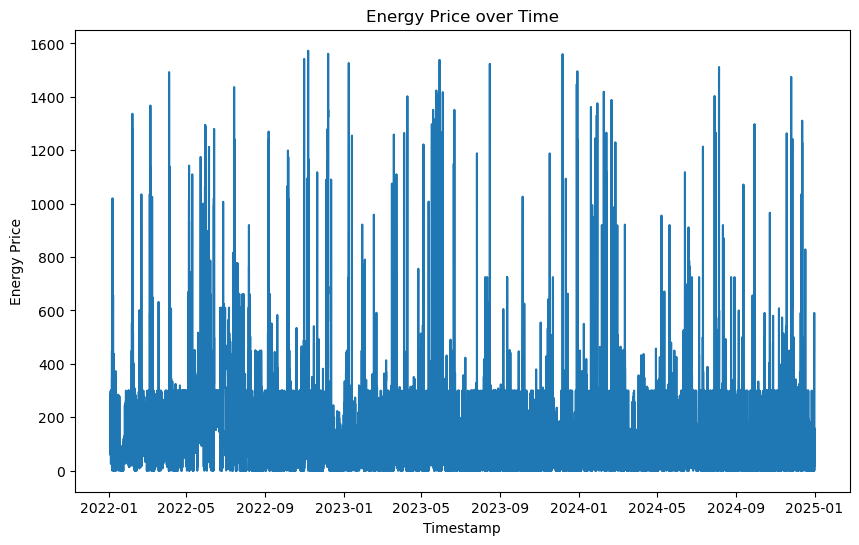

In [25]:
#plot "Energy_Price" against "timestamp", no x-ticks
plt.figure(figsize=(10, 6))
plt.plot(df['Energy_Price'])
plt.title('Energy Price over Time')
plt.xlabel('Timestamp')
plt.ylabel('Energy Price')
plt.show()

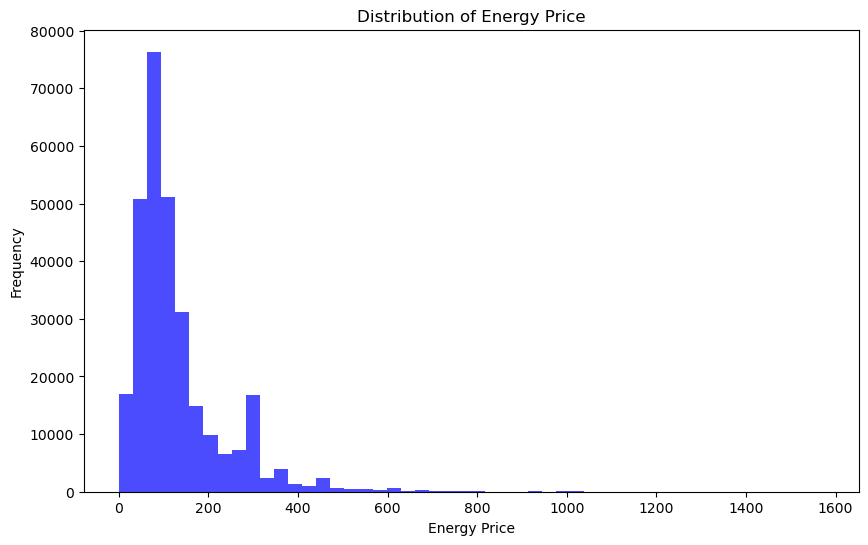

In [26]:
#plot distribution of "Energy_Price"
plt.figure(figsize=(10, 6))
plt.hist(df['Energy_Price'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Energy Price')
plt.xlabel('Energy Price')
plt.ylabel('Frequency')
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x304c22030>,
 'caps': [<matplotlib.lines.Line2D at 0x304c22510>,
 'boxes': [<matplotlib.lines.Line2D at 0x304c21dc0>],
 'medians': [<matplotlib.lines.Line2D at 0x304c22ab0>],
 'fliers': [<matplotlib.lines.Line2D at 0x304c22db0>],
 'means': []}

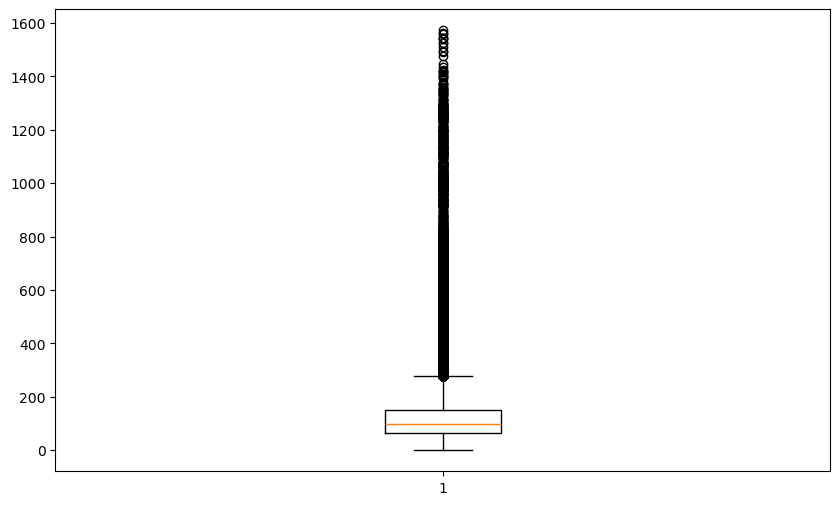

In [27]:
# show boxplot of "Energy_Price"
plt.figure(figsize=(10, 6))
plt.boxplot(df['Energy_Price'])

In [28]:
#how many row are above 3rd quartile
q3 = df['Energy_Price'].quantile(0.75)
q1 = df['Energy_Price'].quantile(0.25)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
upper_bound
#number of rows above upper bound
len(df[df['Energy_Price'] > upper_bound])

#number of rows in total
len(df)

#percentage of rows above upper bound
len(df[df['Energy_Price'] > upper_bound]) / len(df) * 100


11.079802078979654

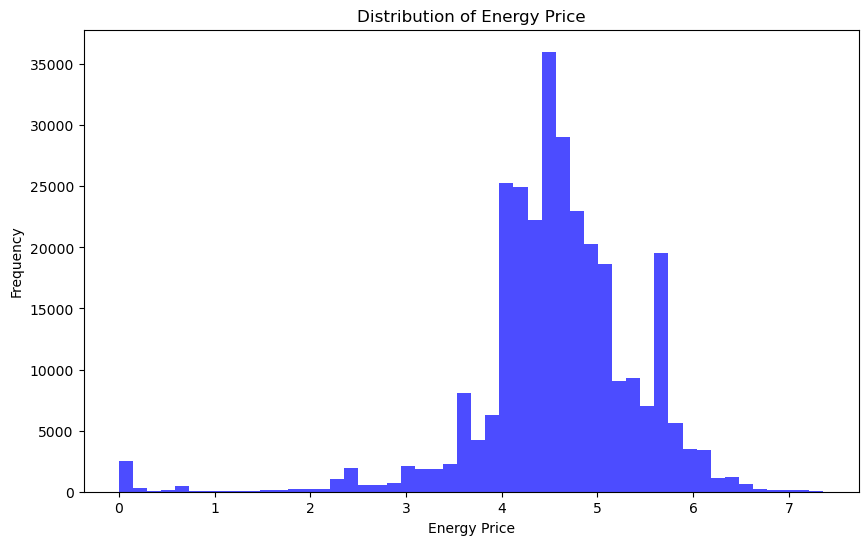

In [29]:
#log transform "Energy_Price"
df['Energy_Price'] = np.log1p(df['Energy_Price'])

#plot distribution of "Energy_Price"
plt.figure(figsize=(10, 6))
plt.hist(df['Energy_Price'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Energy Price')
plt.xlabel('Energy Price')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x600 with 0 Axes>

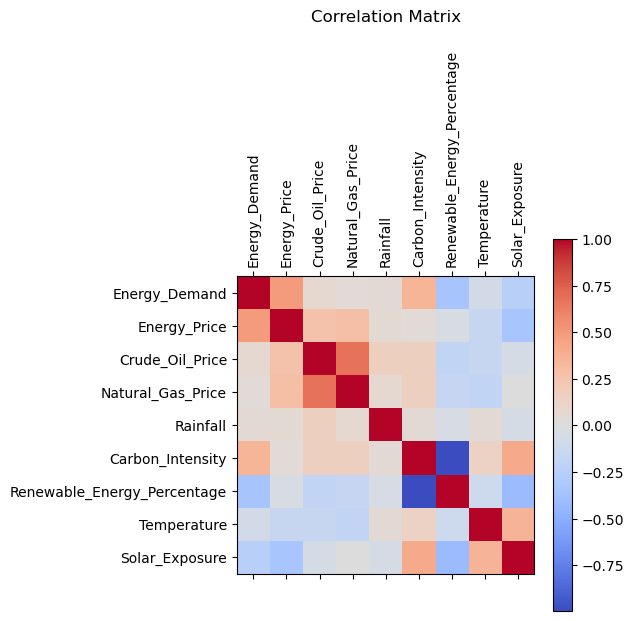

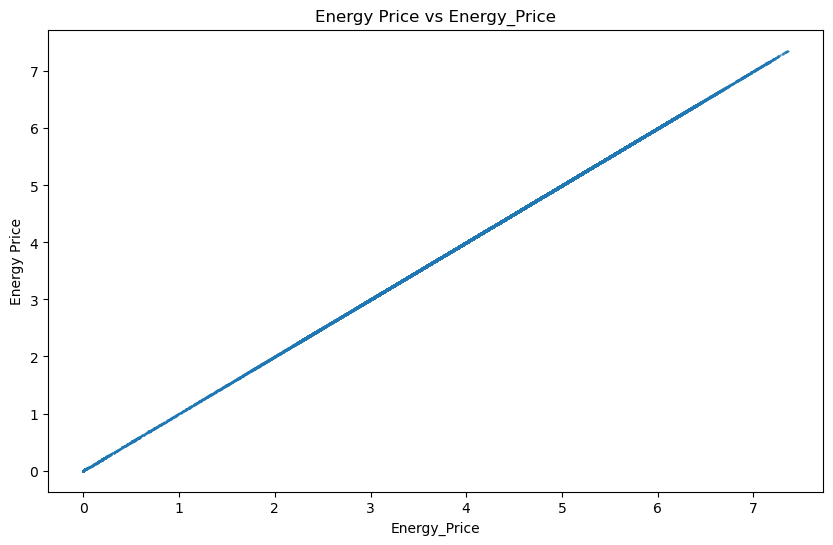

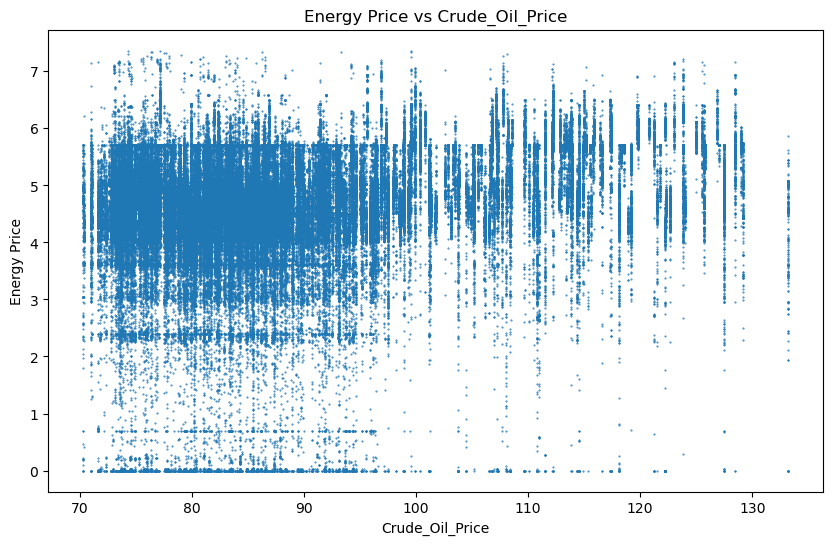

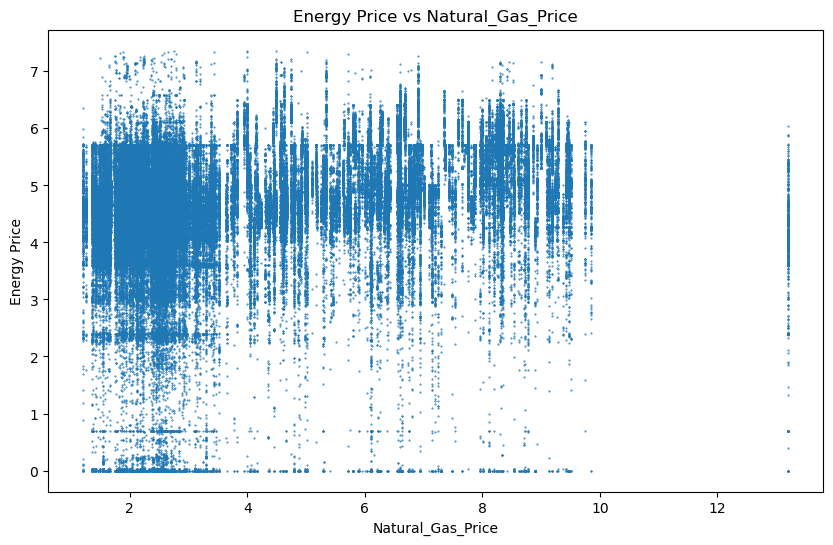

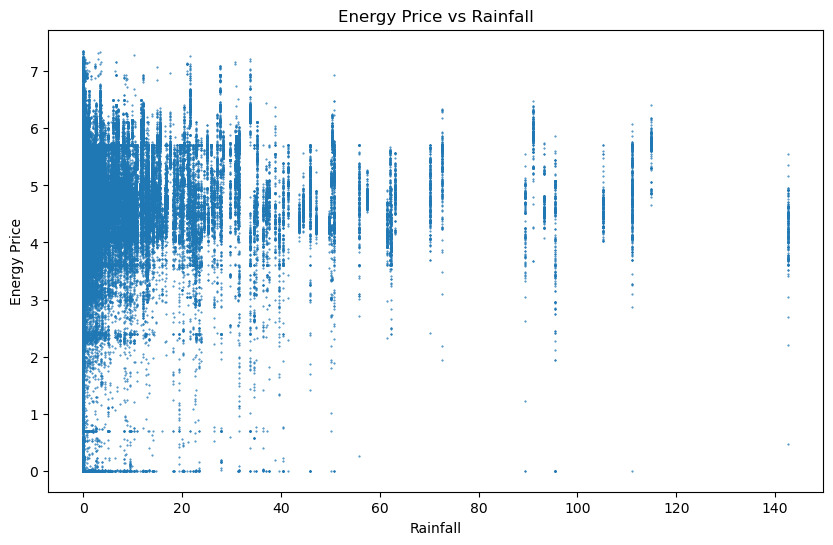

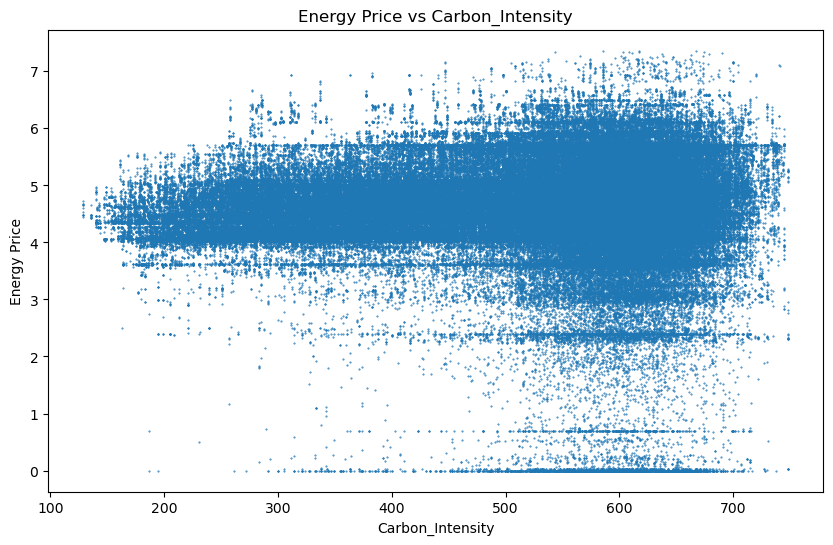

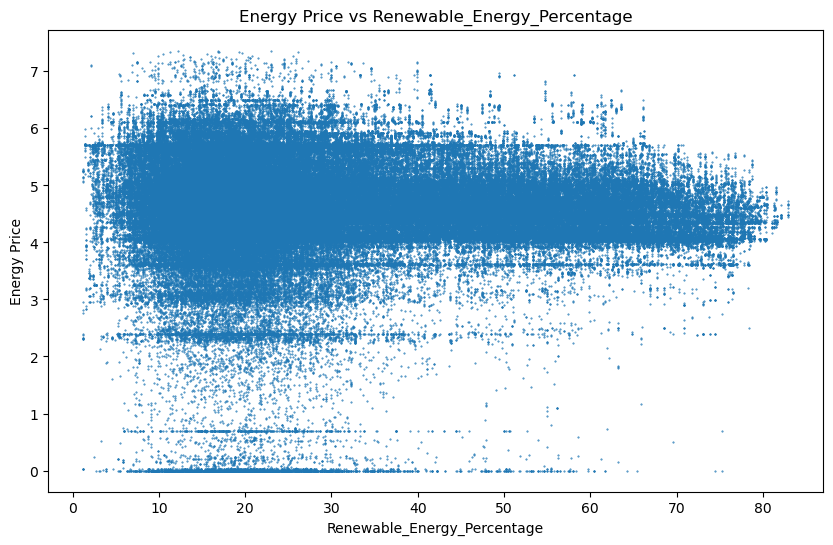

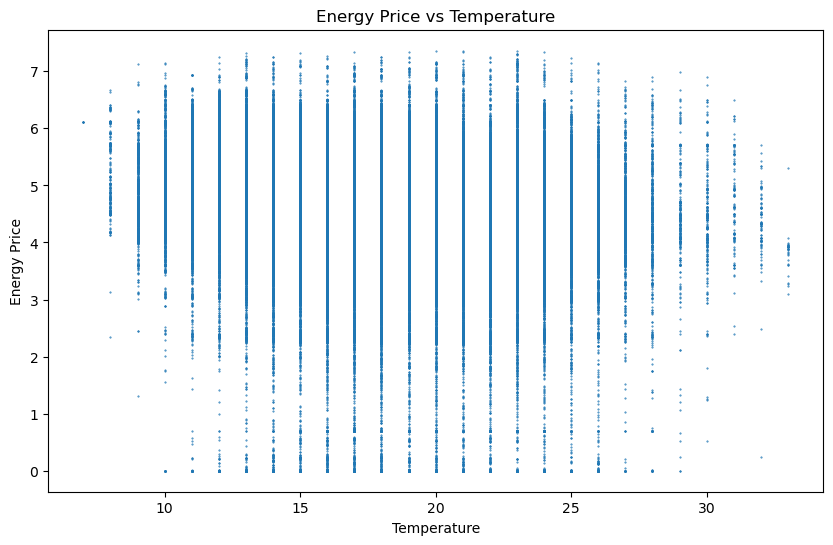

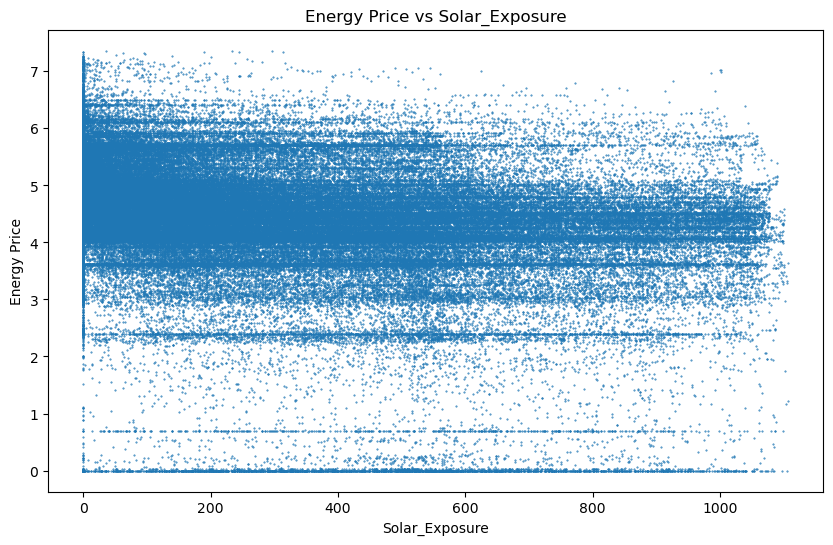

In [31]:
#correlation matrix, all columns except "timestamp"
correlations = df.corr()

#show correlation matrix
plt.figure(figsize=(10, 6))
plt.matshow(correlations, cmap='coolwarm')
plt.title('Correlation Matrix', pad=20)
plt.colorbar()
plt.xticks(range(len(correlations.columns)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations.columns)), correlations.columns)
plt.show()

#plot "Energy_Price" against all other columns in separate plots
columns = df.columns[1:]
for column in columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df[column], df['Energy_Price'],s=0.2)
    plt.title(f'Energy Price vs {column}')
    plt.xlabel(column)
    plt.ylabel('Energy Price')
    plt.show()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   2.8s
[CV] END cols

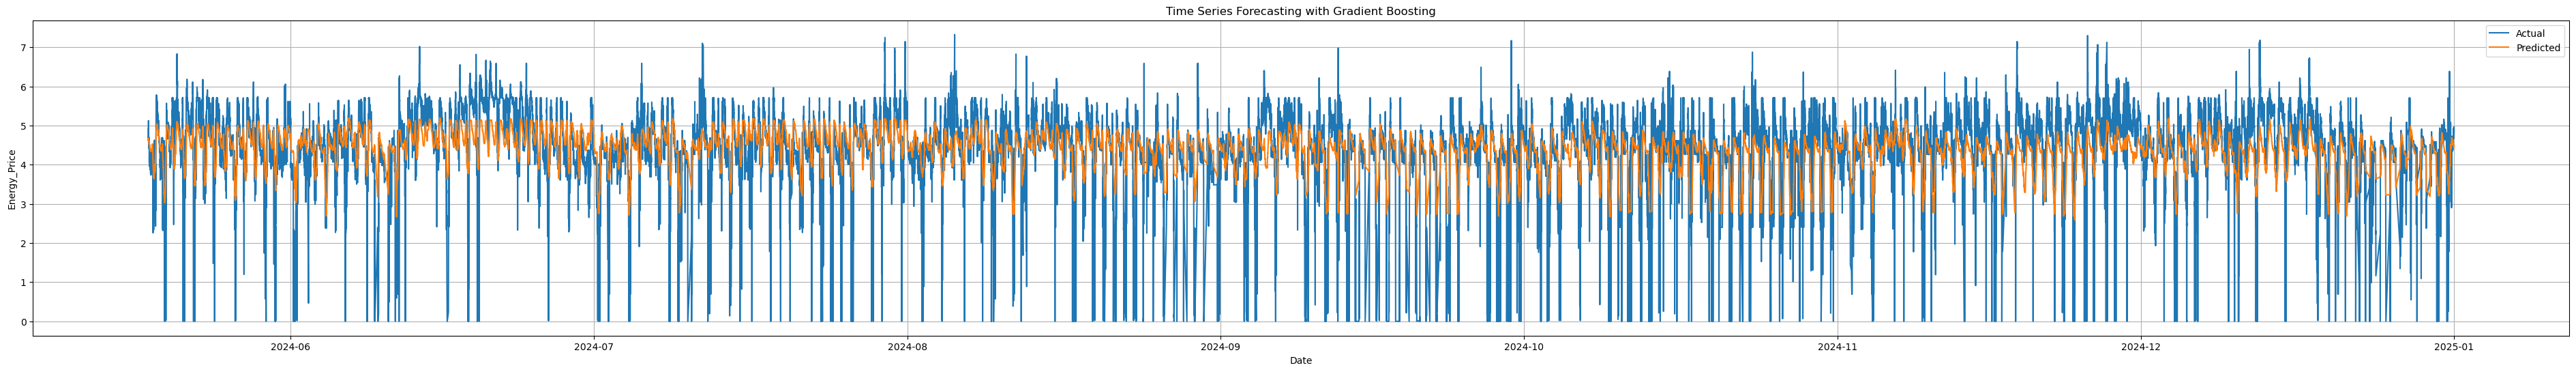

In [32]:
# 1. Prepare the Data
outcome_variable = 'Energy_Price'

#all other columns are predictors
predictor_variables = ['Energy_Demand', 'Crude_Oil_Price', 'Natural_Gas_Price',
                       'Rainfall', 'Solar_Exposure', 'Carbon_Intensity',
                       'Renewable_Energy_Percentage', 'Temperature']

y = df[outcome_variable]
X = df[predictor_variables]

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Initialize and Train the Gradient Boosting Regressor
# You can tune the hyperparameters for better performance
#xgbm = xgb.XGBRegressor(n_estimators=100,  # Number of boosting stages
                                #learning_rate=0.1, # Step size shrinkage to prevent overfitting
                                #max_depth=5,       # Maximum depth of the individual regression estimators
                                #random_state=42)  # For reproducibility

# Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=2,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)
xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 4. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)

# 5. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 6. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(outcome_variable)
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance}")

Energy_Demand: 0.2865516245365143
Crude_Oil_Price: 0.15721909701824188
Natural_Gas_Price: 0.16845861077308655
Rainfall: 0.016210097819566727
Solar_Exposure: 0.29196810722351074
Carbon_Intensity: 0.008279137313365936
Renewable_Energy_Percentage: 0.027177901938557625
Temperature: 0.04413530230522156


In [ ]:
import shap

# Create a SHAP explainer object
#explainer = shap.Explainer(best_model, X_train)

# Get SHAP values for each feature
#shap_values = explainer(X_train)

# Plot feature importance
#shap.summary_plot(shap_values, X_train)

In [35]:
#add additional predictors and rerun the model

# add new features based on time 
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Add lag and rolling features
df['lag_1'] = df['Energy_Price'].shift(1)
df['lag_12'] = df['Energy_Price'].shift(12)
df['lag_288'] = df['Energy_Price'].shift(288)
df['lag_576'] = df['Energy_Price'].shift(576)
df['rolling_mean_24'] = df['Energy_Price'].shift(1).rolling(window=24).mean()
df['rolling_std_24'] = df['Energy_Price'].shift(1).rolling(window=24).std()

Best parameters found:  {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.7s
[

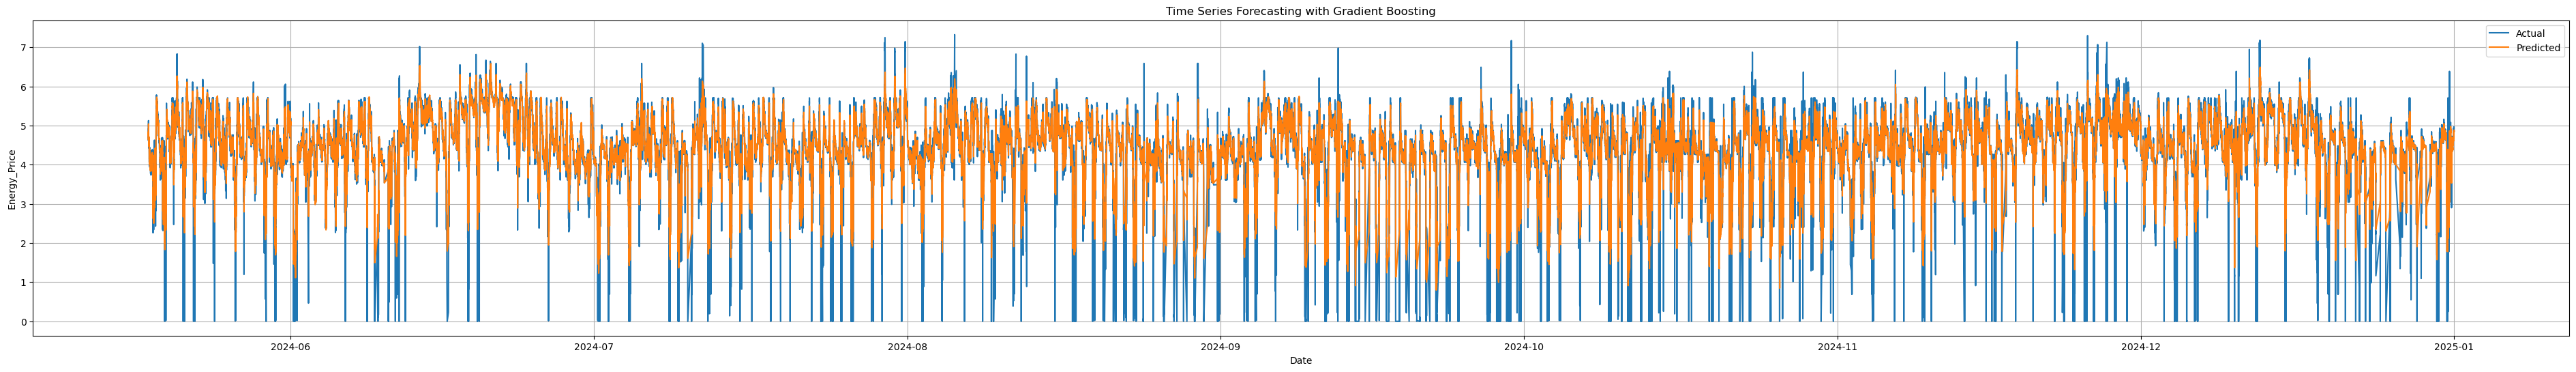

In [36]:
# 1. Prepare the Data
outcome_variable = 'Energy_Price'

#all other columns are predictors
predictor_variables = ['Energy_Demand', 'Crude_Oil_Price', 'Natural_Gas_Price',
                       'Rainfall', 'Solar_Exposure', 'Carbon_Intensity',
                       'Renewable_Energy_Percentage', 'Temperature',
                       'hour', 'dayofweek', 'month', 'lag_1', 'lag_12', 'lag_288',
                       'lag_576','rolling_mean_24', 'rolling_std_24']

y = df[outcome_variable]
X = df[predictor_variables]

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Initialize and Train the Gradient Boosting Regressor
# You can tune the hyperparameters for better performance
#xgbm = xgb.XGBRegressor(n_estimators=100,  # Number of boosting stages
                                #learning_rate=0.1, # Step size shrinkage to prevent overfitting
                                #max_depth=5,       # Maximum depth of the individual regression estimators
                                #random_state=42)  # For reproducibility

# Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],  # -1 = no limit
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=2,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 4. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)

# 5. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 6. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(outcome_variable)
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance}")

Energy_Demand: 0.03040282428264618
Crude_Oil_Price: 0.010266827419400215
Natural_Gas_Price: 0.0075903525575995445
Rainfall: 0.0038872987497597933
Solar_Exposure: 0.010187228210270405
Carbon_Intensity: 0.005379819311201572
Renewable_Energy_Percentage: 0.0064377873204648495
Temperature: 0.008233067579567432
hour: 0.020443525165319443
dayofweek: 0.003299468895420432
month: 0.004513920284807682
lag_1: 0.4233196973800659
lag_12: 0.04001980647444725
lag_288: 0.053263258188962936
lag_576: 0.014264344237744808
rolling_mean_24: 0.330419659614563
rolling_std_24: 0.02807104028761387


In [38]:
#import shap

# Create a SHAP explainer object
#explainer = shap.Explainer(best_model, X_train)

# Get SHAP values for each feature
#shap_values = explainer(X_train)

# Plot feature importance
#shap.summary_plot(shap_values, X_train)

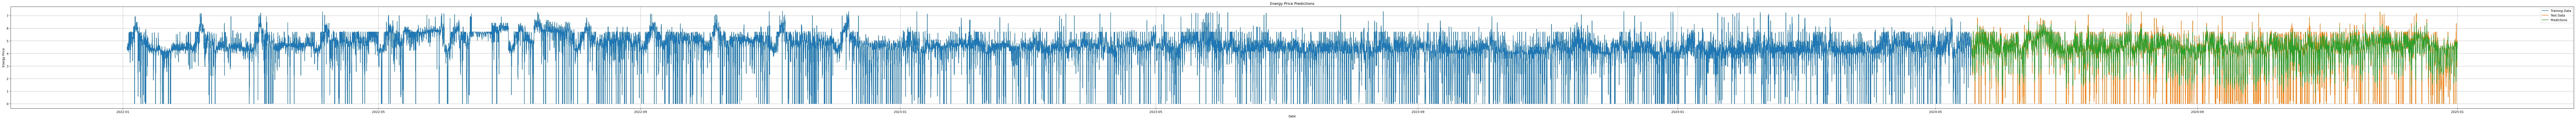

In [39]:
#plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title('Energy Price Predictions')
plt.xlabel('Date')
plt.ylabel('Energy Price')
plt.legend()
plt.grid(True)
plt.show()